In [6]:
### Simple Analysis to histogram S2 signal strength - intended for Xebra leveling ###
import numpy as np
import pymongo 
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import h5py
import snappy
from tqdm import tqdm
import scipy
from scipy.optimize import curve_fit
import os



In [21]:
record_dtype = np.dtype([
    ('integral', np.float64),
    ('baseline', np.float64),
    ('rms', np.float64),
    ('baseline_mode', np.uint16),
    ('baseline_post', np.float64),
    ('rms_post', np.float64),
    ('baseline_mode_post', np.uint16),
    ('length', np.uint16),
    ('width_25pto75p', np.float64),
    ('width_10pto90p', np.float64),
    ('rise_time_area', np.float64),
    ('peak_height', np.float64),
    ('peak_i', np.uint64),
    ('FWHM_peak', np.float64),
    ('FWHM_wf', np.float64),
    ('FWQM_wf', np.float64),
    ('rise_time_peak', np.float64),
    ('quality_cut_flag', np.bool_),
    ('selection_cut_flag', np.bool_),
    ])


In [23]:
infile = 'data.npy'

data = {}

data = np.load(infile)

print(data)


{'channel0': array([ (5836722556.124912, 15389.675, 0.9588404455382554, 15390, 15386.0, 7.0487027548560865, 15390, 124, 41.14879873967749, 82.9017030416939, 24.518751332605518, 807.5878143310547, 52, 48.11817605388882, 48.11817605388882, 76.30055316855078, 21.70882968325236, False, False),
       (52012754.290291436, 15454.125, 4.461992268034538, 15456, 15448.0, 12.760960201456546, 15456, 102, 128.59073294997216, 358.73383955100695, 133.148717948718, 7.1582794189453125, 50, 13.112189440993802, 371.74603174603175, 388.29365079365084, 11.982583774250429, False, False),
       (-29956088.97690963, 15441.475, 16.02184056218261, 15454, 15455.473684210527, 1.1862555441668048, 15456, 108, 133.88888888887857, 214.22222222220563, 107.11111111110273, 8.854293823242237, 57, 20.517640954687067, 79.99158163265321, 99.99585459183686, 14.861469900642987, False, False),
       ...,
       (16428915.302397212, 15989.275, 1.0720890821195783, 15989, 15989.157894736842, 0.9874559494365115, 15988, 102, 13.

In [25]:
for ch in range(0, 1):
    string = 'channel'
    string += str(ch)
    int_array = data[string][['integral']]
    int_array= int_array / PMTgain
    cut_mask= data[string]['rise_time_area']<=10
    bins_integral = np.logspace(0, 6, 50)
    plt.hist(int_array[cut_mask].T, bins = bins_integral, range=((bins_integral[0], bins_integral[-1])), label=string+' S1-like', histtype='step', stacked='true')
    plt.hist(int_array[~cut_mask].T, bins = bins_integral, range=((bins_integral[0], bins_integral[-1])), label=string+' S2-like', histtype='step', stacked='true')
    plt.hist(int_array.T, bins = bins_integral, range=((bins_integral[0], bins_integral[-1])), label=string+' total', histtype='step', stacked='true')
    
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Number of events')
plt.xlabel('Signal [PE]')
plt.legend()
plt.show()


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

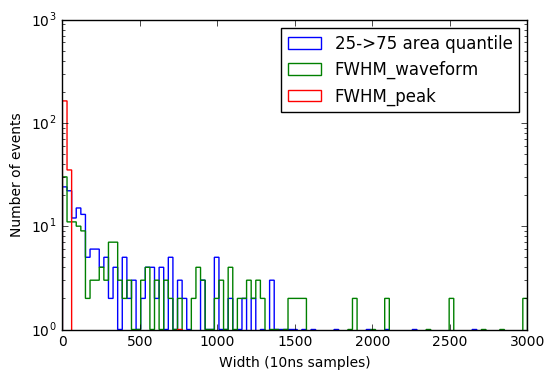

In [276]:
for ch in range(0, 1):
    string = 'channel'
    string += str(ch)
    width_range =[0,3000]
    
    int_array = data[string]['width_25pto75p']
    plt.hist(int_array, bins = 101, range = width_range, label='25->75 area quantile', histtype='step', stacked='true')
    int_array = data[string]['FWHM_wf']
    plt.hist(int_array, bins = 101, range = width_range, label='FWHM_waveform', histtype='step', stacked='true')
    int_array = data[string]['FWHM_peak']
    plt.hist(int_array, bins = 101, range = width_range, label='FWHM_peak', histtype='step', stacked='true')   

plt.yscale('log')
plt.ylabel('Number of events')
plt.xlabel('Width (10ns samples)')
plt.legend()
plt.show()

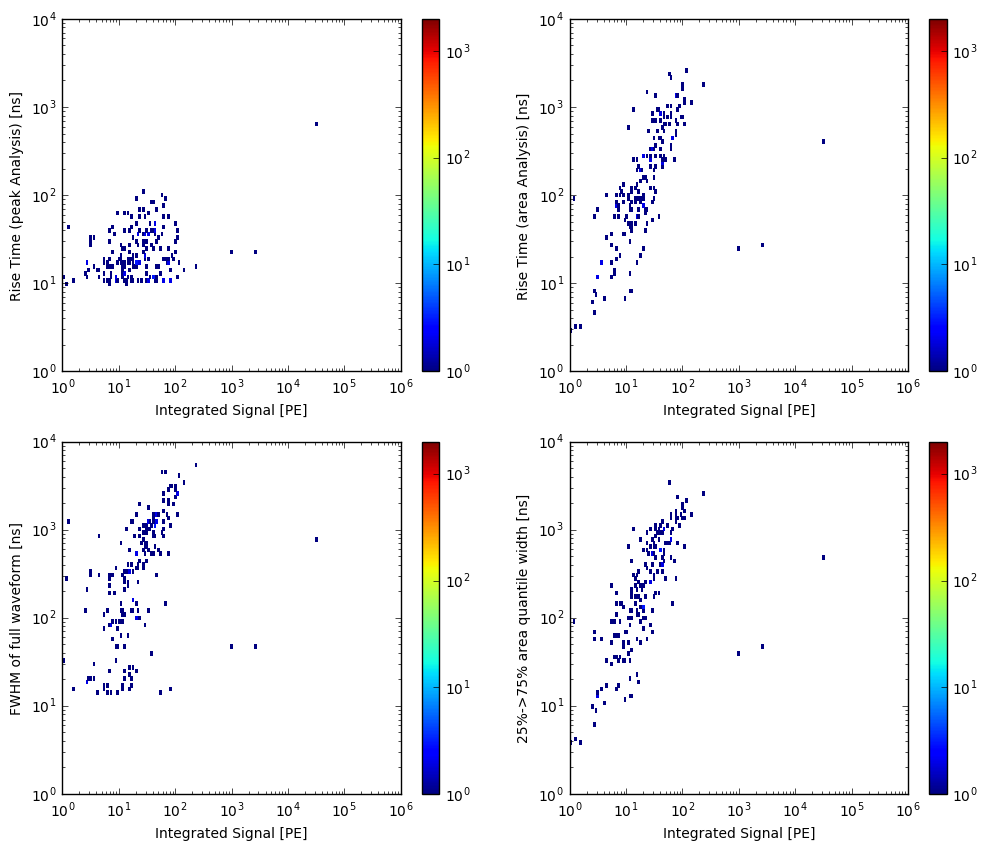

In [277]:
##### Assessing discrimination power of rise_time / width vs. integrated signal (in both analysis approaches)  #####

string = 'channel0'
        
integral = data[string]['integral']
integral = integral / PMTgain
rise_time_peak = data[string]['rise_time_peak']
rise_time_area = data[string]['rise_time_area']
FWHM_wf = data[string]['FWHM_wf']
width_25pto75p = data[string]['width_25pto75p']
     
bins_rise_time = np.logspace(0, 4, 100)
bins_integral = np.logspace(0, 6, 200)
bins_width = np.logspace(0, 4, 100)
histo_max= 2*10**3
      
fig, ([ax1, ax2],[ax3, ax4]) = plt.subplots(2, 2, sharex=False, figsize=(12, 10))
    
counts1, _, _ = np.histogram2d(integral, rise_time_peak, bins=(bins_integral, bins_rise_time), range=((bins_integral[0], bins_integral[-1]),(bins_rise_time[0], bins_rise_time[-1])) )  
im1 = ax1.pcolormesh(bins_integral, bins_rise_time, counts1.T, norm=mcolors.LogNorm(), vmin=1, vmax=histo_max)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel('Rise Time (peak Analysis) [ns]')
ax1.set_xlabel('Integrated Signal [PE]')
plt.colorbar(im1 ,ax=ax1)

counts2, _, _ = np.histogram2d(integral, rise_time_area, bins=(bins_integral, bins_rise_time), range=((bins_integral[0], bins_integral[-1]),(bins_rise_time[0], bins_rise_time[-1])) )  
im2 = ax2.pcolormesh(bins_integral, bins_rise_time, counts2.T, norm=mcolors.LogNorm(), vmin=1, vmax=histo_max)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylabel('Rise Time (area Analysis) [ns]')
ax2.set_xlabel('Integrated Signal [PE]')
plt.colorbar(im2 ,ax=ax2)

counts3, _, _ = np.histogram2d(integral, FWHM_wf, bins=(bins_integral, bins_width), range=((bins_integral[0], bins_integral[-1]),(bins_width[0], bins_width[-1])) )  
im3 = ax3.pcolormesh(bins_integral, bins_width, counts3.T, norm=mcolors.LogNorm(), vmin=1, vmax=histo_max)
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylabel('FWHM of full waveform [ns]')
ax3.set_xlabel('Integrated Signal [PE]')
plt.colorbar(im3 ,ax=ax3)

counts4, _, _ = np.histogram2d(integral, width_25pto75p, bins=(bins_integral, bins_width), range=((bins_integral[0], bins_integral[-1]),(bins_width[0], bins_width[-1])) )  
im4 = ax4.pcolormesh(bins_integral, bins_width, counts4.T, norm=mcolors.LogNorm(), vmin=1, vmax=histo_max)
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_ylabel('25%->75% area quantile width [ns]')
ax4.set_xlabel('Integrated Signal [PE]')
plt.colorbar(im4 ,ax=ax4)

    
plt.savefig('Signal_Discr.png',bbox_inches='tight')
plt.show()


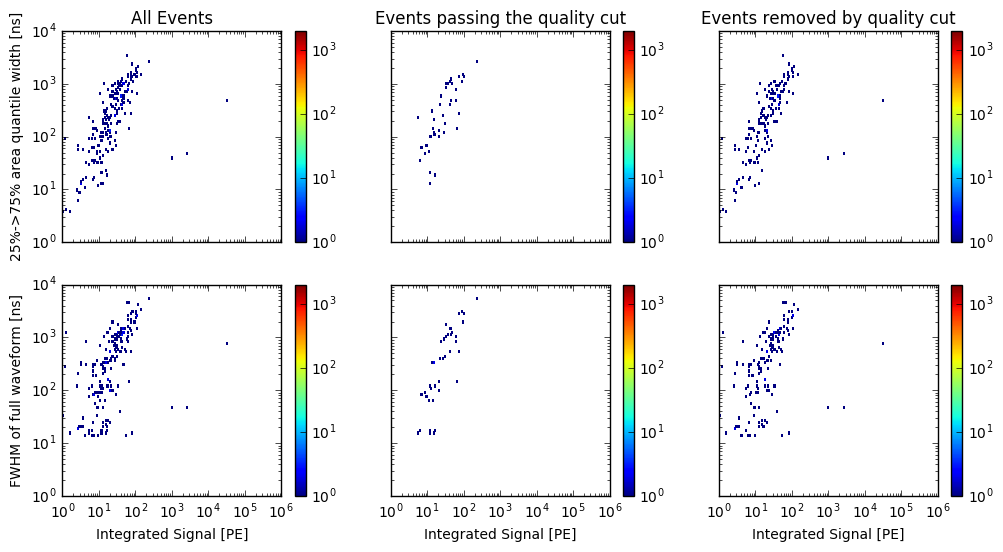

In [278]:
##### Testing Quality Cut  #####

string = 'channel0'
        
integral = data[string]['integral']
integral = integral / PMTgain
quality_cut_flag = data[string]['quality_cut_flag']
FWHM_wf = data[string]['FWHM_wf']
width_25pto75p = data[string]['width_25pto75p']
     
bins_integral = np.logspace(0, 6, 200)
bins_width = np.logspace(0, 4, 100)
histo_max= 2*10**3
      
fig, ([ax1, ax2, ax3],[ax4, ax5, ax6]) = plt.subplots(2, 3, sharey='row', sharex='col', figsize=(12, 6))

counts1, _, _ = np.histogram2d(integral, width_25pto75p, bins=(bins_integral, bins_width), range=((bins_integral[0], bins_integral[-1]),(bins_width[0], bins_width[-1])) )  
im1 = ax1.pcolormesh(bins_integral, bins_width, counts1.T, norm=mcolors.LogNorm(), vmin=1, vmax=histo_max)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel('25%->75% area quantile width [ns]')
ax1.set_title("All Events")
plt.colorbar(im1 ,ax=ax1)

counts2, _, _ = np.histogram2d(integral[quality_cut_flag], width_25pto75p[quality_cut_flag], bins=(bins_integral, bins_width), range=((bins_integral[0], bins_integral[-1]),(bins_width[0], bins_width[-1])) )  
im2 = ax2.pcolormesh(bins_integral, bins_width, counts2.T, norm=mcolors.LogNorm(), vmin=1, vmax=histo_max)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_title("Events passing the quality cut")
plt.colorbar(im2 ,ax=ax2)

counts3, _, _ = np.histogram2d(integral[~quality_cut_flag], width_25pto75p[~quality_cut_flag], bins=(bins_integral, bins_width), range=((bins_integral[0], bins_integral[-1]),(bins_width[0], bins_width[-1])) )  
im3 = ax3.pcolormesh(bins_integral, bins_width, counts3.T, norm=mcolors.LogNorm(), vmin=1, vmax=histo_max)
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_title("Events removed by quality cut")
plt.colorbar(im3 ,ax=ax3)


counts4, _, _ = np.histogram2d(integral, FWHM_wf, bins=(bins_integral, bins_width), range=((bins_integral[0], bins_integral[-1]),(bins_width[0], bins_width[-1])) )  
im4 = ax4.pcolormesh(bins_integral, bins_width, counts4.T, norm=mcolors.LogNorm(), vmin=1, vmax=histo_max)
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_ylabel('FWHM of full waveform [ns]')
ax4.set_xlabel('Integrated Signal [PE]')
plt.colorbar(im4 ,ax=ax4)

counts5, _, _ = np.histogram2d(integral[quality_cut_flag], FWHM_wf[quality_cut_flag], bins=(bins_integral, bins_width), range=((bins_integral[0], bins_integral[-1]),(bins_width[0], bins_width[-1])) )  
im5 = ax5.pcolormesh(bins_integral, bins_width, counts5.T, norm=mcolors.LogNorm(), vmin=1, vmax=histo_max)
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel('Integrated Signal [PE]')
plt.colorbar(im5 ,ax=ax5)

counts6, _, _ = np.histogram2d(integral[~quality_cut_flag], FWHM_wf[~quality_cut_flag], bins=(bins_integral, bins_width), range=((bins_integral[0], bins_integral[-1]),(bins_width[0], bins_width[-1])) )  
im6 = ax6.pcolormesh(bins_integral, bins_width, counts6.T, norm=mcolors.LogNorm(), vmin=1, vmax=histo_max)
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_xlabel('Integrated Signal [PE]')
plt.colorbar(im6 ,ax=ax6)

    
plt.savefig('Signal_width_cut.png',bbox_inches='tight')
plt.show()


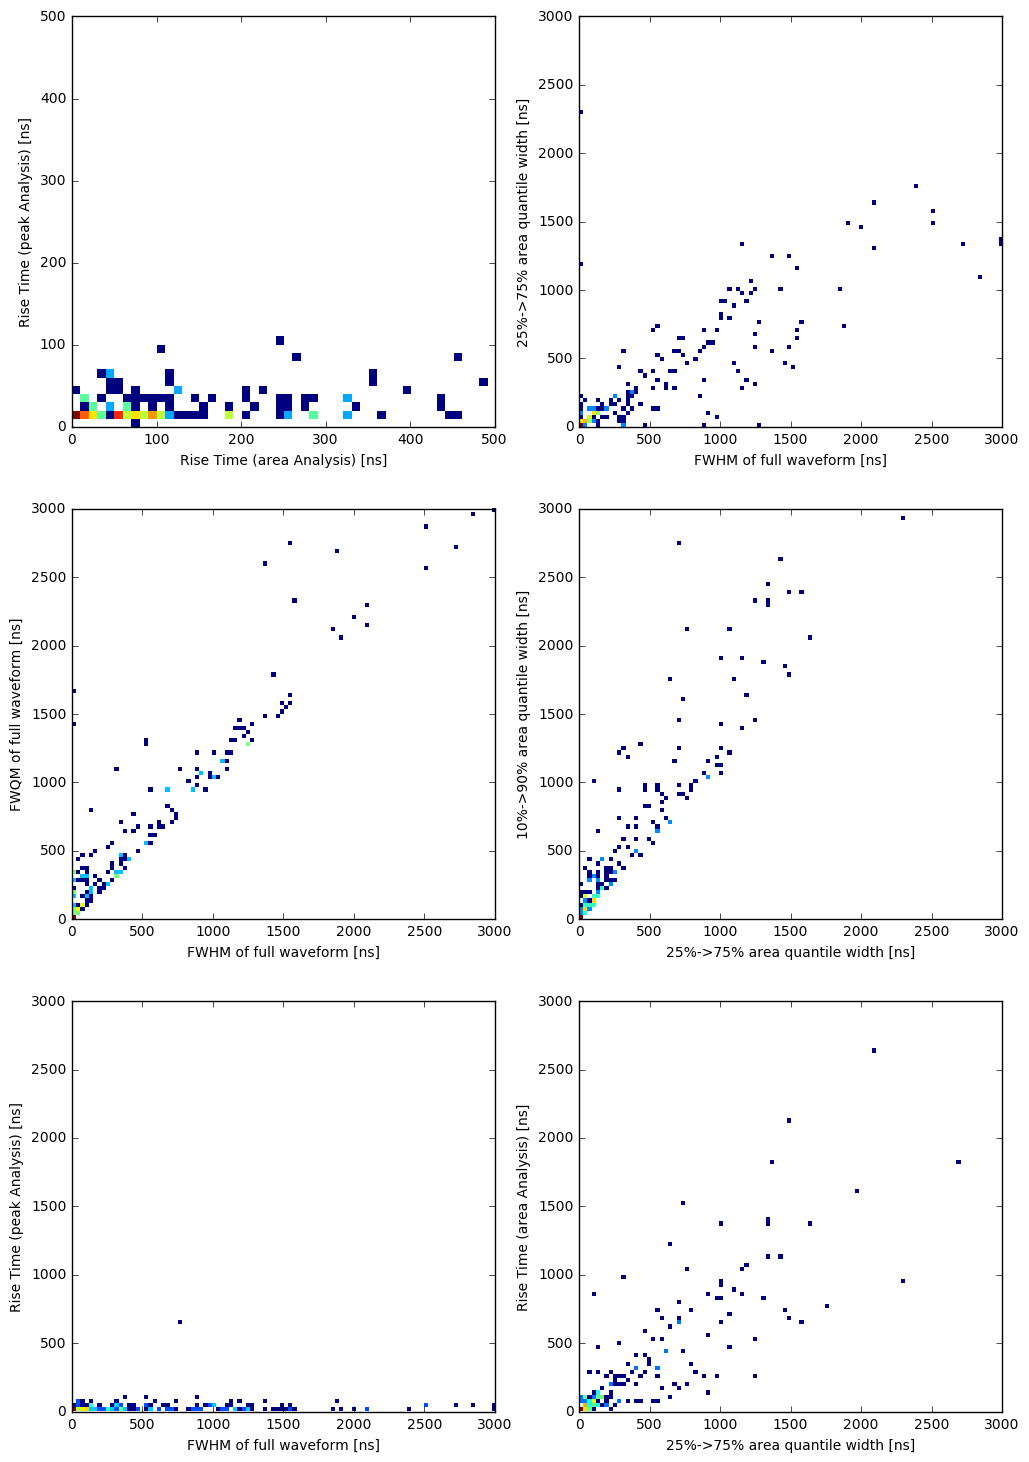

In [279]:
##### Comparison of rise_time, width etc. between Area & Peak analysis #####

string = 'channel0'
    
rise_time_peak = data[string]['rise_time_peak']
rise_time_area = data[string]['rise_time_area']
FWHM_wf = data[string]['FWHM_wf']
FWQM_wf = data[string]['FWQM_wf']
FWHM_peak = data[string]['FWHM_peak']

width_25pto75p = data[string]['width_25pto75p']
width_10pto90p = data[string]['width_10pto90p']
     
rise_time_range = [0,500]
width_range =[0,3000]
    
fig, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3, 2, sharex=False, figsize=(12, 18))

ax1.hist2d(rise_time_area, rise_time_peak, bins=(50,50), range=(rise_time_range, rise_time_range), norm=mcolors.LogNorm(), weights=None)      
ax1.set_xlabel('Rise Time (area Analysis) [ns]')
ax1.set_ylabel('Rise Time (peak Analysis) [ns]')

ax2.hist2d(FWHM_wf, width_25pto75p, bins=(100,100), range=(width_range, width_range), norm=mcolors.LogNorm(), weights=None)   
ax2.set_xlabel('FWHM of full waveform [ns]')
ax2.set_ylabel('25%->75% area quantile width [ns]')

ax3.hist2d(FWHM_wf, FWQM_wf, bins=(100,100), range=(width_range, width_range), norm=mcolors.LogNorm(), weights=None)   
ax3.set_xlabel('FWHM of full waveform [ns]')
ax3.set_ylabel('FWQM of full waveform [ns]')
    
ax4.hist2d(width_25pto75p, width_10pto90p, bins=(100,100 ), range=(width_range, width_range), norm=mcolors.LogNorm(), weights=None)   
ax4.set_xlabel('25%->75% area quantile width [ns]')
ax4.set_ylabel('10%->90% area quantile width [ns]')

ax5.hist2d(FWHM_wf, rise_time_peak, bins=(100, 100), range=(width_range, width_range), norm=mcolors.LogNorm(), weights=None)   
ax5.set_xlabel('FWHM of full waveform [ns]')
ax5.set_ylabel('Rise Time (peak Analysis) [ns]')

ax6.hist2d(width_25pto75p, rise_time_area, bins=(100,100 ), range=(width_range, width_range), norm=mcolors.LogNorm(), weights=None)   
ax6.set_xlabel('25%->75% area quantile width [ns]')
ax6.set_ylabel('Rise Time (area Analysis) [ns]')

plt.show()
    

    